In [4]:
pip install pandas numpy matplotlib seaborn scikit-learn pyspark

Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from pyspark.sql import SparkSession

Load dataset


In [9]:
import pandas as pd

stations = pd.read_csv("stations.csv")
# station_hour = pd.read_csv("station_hour.csv")
station_day = pd.read_csv("station_day.csv")
city_hour = pd.read_csv("city_hour.csv")
city_day = pd.read_csv("city_day.csv")

print(stations.shape)
# print(station_hour.shape)
print(station_day.shape)
print(city_hour.shape)
print(city_day.shape)

/tmp/ipython-input-472/2891189815.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv("station_hour.csv")


(230, 5)
(1546987, 16)
(108035, 16)
(707875, 16)
(29531, 16)


## Data clean

In [10]:
def clean_dataset(df):

    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])

    if "Datetime" in df.columns:
        df["Datetime"] = pd.to_datetime(df["Datetime"])


    num_cols = df.select_dtypes(include=["float64","int64"]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    return df


station_hour = clean_dataset(station_hour)
station_day = clean_dataset(station_day)
city_hour = clean_dataset(city_hour)
city_day = clean_dataset(city_day)

Data intgeration


In [11]:
station_full = pd.merge(
    station_day,
    stations,
    on="StationId",
    how="left"
)

print(station_full.head())

  StationId       Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO    SO2  \
0     AP001 2017-11-24  71.36  115.75  1.75  20.65  12.40  12.19  0.10  10.76   
1     AP001 2017-11-25  81.40  124.50  1.44  20.50  12.08  10.72  0.12  15.24   
2     AP001 2017-11-26  78.32  129.06  1.26  26.00  14.85  10.28  0.14  26.96   
3     AP001 2017-11-27  88.76  135.32  6.60  30.85  21.77  12.91  0.11  33.59   
4     AP001 2017-11-28  64.18  104.09  2.56  28.07  17.01  11.42  0.09  19.00   

       O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  \
0  109.26     0.17     5.92    0.10  132.0        NaN   
1  127.09     0.20     6.50    0.06  184.0   Moderate   
2  117.44     0.22     7.95    0.08  197.0   Moderate   
3  111.81     0.29     7.63    0.12  198.0   Moderate   
4  138.18     0.17     5.02    0.07  188.0   Moderate   

                      StationName       City           State  Status  
0  Secretariat, Amaravati - APPCB  Amaravati  Andhra Pradesh  Active  
1  Secretariat, Amaravati - 

##**EDA**

---



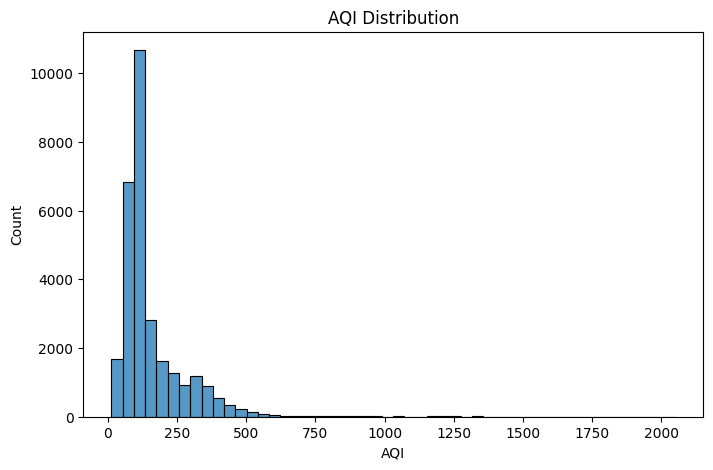

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(city_day["AQI"], bins=50)
plt.title("AQI Distribution")
plt.show()

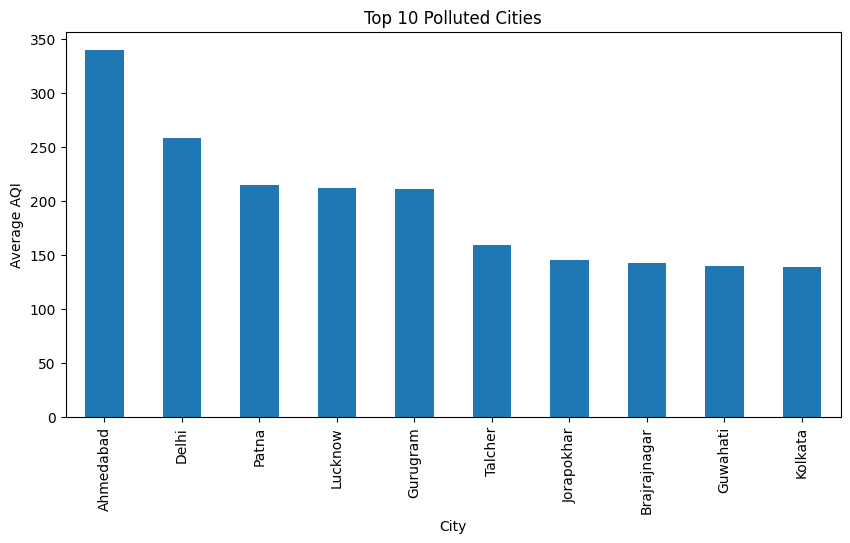

In [13]:
top_cities = city_day.groupby("City")["AQI"].mean().sort_values(ascending=False).head(10)

top_cities.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Polluted Cities")
plt.ylabel("Average AQI")
plt.show()

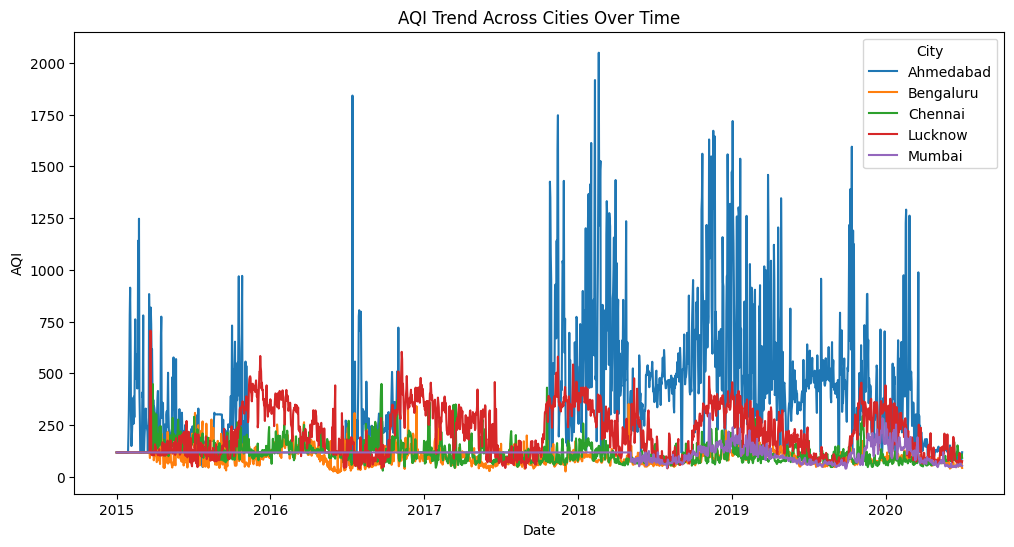

In [14]:
top_cities = city_day["City"].value_counts().head(5).index

df_top = city_day[city_day["City"].isin(top_cities)]

plt.figure(figsize=(12,6))
sns.lineplot(data=df_top, x="Date", y="AQI", hue="City")

plt.title("AQI Trend Across Cities Over Time")
plt.show()

### **Machine learning model**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

features = ["PM2.5","PM10","NO2","CO","SO2","O3"]

df = city_day.dropna(subset=["AQI"])

X = df[features]
y = df["AQI"]

X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

model = RandomForestRegressor(n_estimators=200)

model.fit(X_train,y_train)

pred = model.predict(X_test)

print("R2 Score:", r2_score(y_test,pred))
print("MSE:", mean_squared_error(y_test,pred))

R2 Score: 0.882008001635784
MSE: 1816.4234180522005


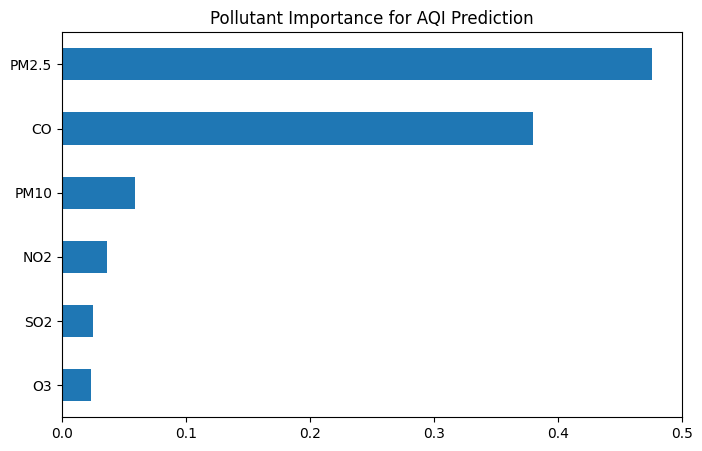

In [16]:
importance = pd.Series(
    model.feature_importances_,
    index=features
)

importance.sort_values().plot(kind="barh", figsize=(8,5))

plt.title("Pollutant Importance for AQI Prediction")
plt.show()

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg,year

spark = SparkSession.builder.appName("AirQualityBDA").getOrCreate()

df = spark.read.csv("city_day.csv", header=True, inferSchema=True)

df = df.dropna(subset=["AQI"])

df.createOrReplaceTempView("aqi")

result = spark.sql("""

SELECT
City,
year(Date) as Year,
AVG(AQI) as Avg_AQI

FROM aqi

GROUP BY City,Year
ORDER BY Year

""")

result.show()

+-------------+----+------------------+
|         City|Year|           Avg_AQI|
+-------------+----+------------------+
|      Chennai|2015|148.33333333333334|
|        Delhi|2015|297.02465753424656|
|        Patna|2015|350.55555555555554|
|    Bengaluru|2015|112.57342657342657|
|    Hyderabad|2015| 143.4191176470588|
|    Ahmedabad|2015| 310.9505703422053|
|      Lucknow|2015|202.23591549295776|
|      Lucknow|2016|242.97305389221557|
|    Bengaluru|2016|105.58404558404558|
|    Hyderabad|2016|124.24035608308606|
|    Ahmedabad|2016| 310.1623931623932|
|        Delhi|2016|301.36986301369865|
|        Patna|2016|252.32628398791542|
|     Gurugram|2016|226.71308016877637|
|Visakhapatnam|2016|103.97604790419162|
|      Chennai|2016|138.56586826347305|
|      Chennai|2017|104.53739612188366|
|     Gurugram|2017|284.70212765957444|
| Brajrajnagar|2017|             247.6|
|        Patna|2017|326.36805555555554|
+-------------+----+------------------+
only showing top 20 rows


In [18]:
result.write.parquet("processed_air_quality")

In [20]:
!pip install streamlit
import streamlit as st
import pandas as pd
import plotly.express as px

df = pd.read_csv("city_day.csv")

city = st.selectbox("Select City", df["City"].unique())

city_df = df[df["City"] == city]

fig = px.line(city_df, x="Date", y="AQI")

st.plotly_chart(fig)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.2 MB/s eta 0:00:00


2026-03-01 12:46:41.030 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-03-01 12:46:41.032 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-03-01 12:46:41.035 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-03-01 12:46:41.035 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-03-01 12:46:41.037 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2026-03-01 12:46:41.037 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

DeltaGenerator()